In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch.nn as nn
from DNN import DeepNet
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device) # default tensor device
print("I'm using: ", device)


I'm using:  cuda
I'm using:  cuda


In [2]:
def convert(x):
  return x.cpu().detach().numpy()

def L2_err(y,y_pred):
  return np.linalg.norm(y-y_pred,2)

## A simple ODE

$
\begin{cases}
    \displaystyle \frac{dy(t)}{dt} = - 2y(t),\ \ t\in (0,1)\\[15pt]
    y(0) = 1 
\end{cases}
$

Define the the FNN with 3 layer, 5 neuron and tanh (https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#tanh) as activation function

In [3]:
input = 1
output = 1
hidden_layer = 3*[5]
activation_function = nn.Tanh()

FNN = DeepNet(activation_function,input,hidden_layer,output)
FNN

DeepNet(
  (activation): Tanh()
  (hidden): ModuleList(
    (0): Linear(in_features=1, out_features=5, bias=True)
    (1-2): 2 x Linear(in_features=5, out_features=5, bias=True)
  )
  (output): Linear(in_features=5, out_features=1, bias=False)
)

Using torch.rand define the points that will be used for training. For the test use torch.linspace


In [4]:
t0 = torch.Tensor([0]).to(device)
y0 = torch.Tensor([1]).to(device)  

n_train_points = 50
n_test_points  = 100

t_train = torch.rand([n_train_points, 1])
t_sort_train,_ = torch.sort(t_train,0)
t_test  = torch.linspace(0,1,n_test_points).unsqueeze(1)

Visualize the data

Text(0.5, 1.0, 'Collocation Points')

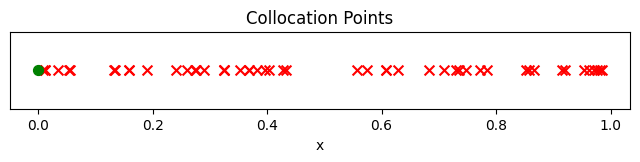

In [5]:
plt.figure(figsize=(8, 1),num =1)  
plt.scatter(convert(t_train), np.zeros_like(convert(t_train)), color='red', s=50, marker='x', label='Collocation Points')
plt.scatter(convert(t0), np.zeros_like(convert(t0)), color='green', s=50, label='Collocation Points')
plt.xlabel('x')
plt.yticks([])  
plt.title('Collocation Points')


Exact solution

In [ ]:
def exact_sol(t):
    return np.exp(-2*convert(t))

y_exact_train = exact_sol(t_train)
y_exact_test  = exact_sol(t_test)
y_exact_train_sort = exact_sol(t_sort_train)


Definition of the loss function for the training, where the metric will be define later some examples can be https://pytorch.org/docs/stable/nn.html#loss-functions

In [7]:
def eval_loss_ode(NN,NN_x,metric):
    return metric(NN_x, - 2 * NN)

def eval_loss_IC(NN_0,y_0):
    return (NN_0 - y_0).pow(2).squeeze()

Training of the network, where the optimzer from here https://pytorch.org/docs/stable/optim.html

In [8]:
n_epochs = 2000
learining_rate = 1e-3
optimizer = torch.optim.Adam(FNN.parameters(),learining_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,50,0.98)
loss_values = np.empty([n_epochs+1,3]); #total,ode, 0

MSE =  torch.nn.MSELoss()

STEP = 200#save every STEP epochs
assert n_epochs%STEP == 0

err = np.empty([int(n_epochs/STEP)+1,2])
y_animate =  np.empty([int(n_epochs/STEP)+1,n_train_points])
err_animate = np.empty([int(n_epochs/STEP)+1,n_train_points])
k   = 0 

for epoch in range(n_epochs+1):
    
    t_train.requires_grad_(True)
    y_NN = FNN(t_train)
    y_NN_t = torch.autograd.grad(y_NN.sum(),t_train,create_graph =True)[0] 
    loss_ode = eval_loss_ode(y_NN,y_NN_t,MSE)
    
    y_NN_0 = FNN(t0)
    loss_IC = eval_loss_IC(y_NN_0,y0)

    loss = loss_ode + loss_IC
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    loss_values[epoch,:] = np.stack([convert(loss),convert(loss_ode),convert(loss_IC)])

    if epoch%STEP == 0:
        lr = np.array(scheduler.get_last_lr())
        y_NN_test =  FNN(t_test)
        err[k,:]  = [L2_err(convert(y_NN),y_exact_train), L2_err(convert(y_NN_test),y_exact_test)]
        y_animate[k,:]  = convert(FNN(t_sort_train).squeeze())
        err_animate[k,:]= (np.abs(y_animate[k,:] - y_exact_train_sort.squeeze()))
        print(f'Epoch {epoch} || learning rate {lr.squeeze():.2e}  || Error  Train {err[k,0]:.2e} || Error Test  {err[k,1]:.2e}''\n'
              f'Global loss {loss_values[epoch,0]:.2e} || loss ode {loss_values[epoch,1]:.2e} || loss IC {loss_values[epoch,2]:.2e}','\n')
        k+=1


Epoch 0 || learning rate 1.00e-03  || Error  Train 7.43e+00 || Error Test  1.05e+01
Global loss 8.55e+00 || loss ode 8.30e+00 || loss IC 2.50e-01 

Epoch 200 || learning rate 9.22e-04  || Error  Train 1.32e+00 || Error Test  1.75e+00
Global loss 2.68e-01 || loss ode 6.47e-02 || loss IC 2.03e-01 

Epoch 400 || learning rate 8.51e-04  || Error  Train 7.96e-01 || Error Test  1.04e+00
Global loss 1.60e-01 || loss ode 7.31e-02 || loss IC 8.66e-02 

Epoch 600 || learning rate 7.85e-04  || Error  Train 5.06e-01 || Error Test  6.48e-01
Global loss 1.10e-01 || loss ode 7.27e-02 || loss IC 3.76e-02 

Epoch 800 || learning rate 7.24e-04  || Error  Train 3.20e-01 || Error Test  4.08e-01
Global loss 6.32e-02 || loss ode 4.92e-02 || loss IC 1.40e-02 

Epoch 1000 || learning rate 6.68e-04  || Error  Train 1.42e-01 || Error Test  1.90e-01
Global loss 1.93e-02 || loss ode 1.77e-02 || loss IC 1.53e-03 

Epoch 1200 || learning rate 6.16e-04  || Error  Train 6.69e-02 || Error Test  9.92e-02
Global loss 4.

# Visualization of the results
Value of the loss function at the vary of the epochs

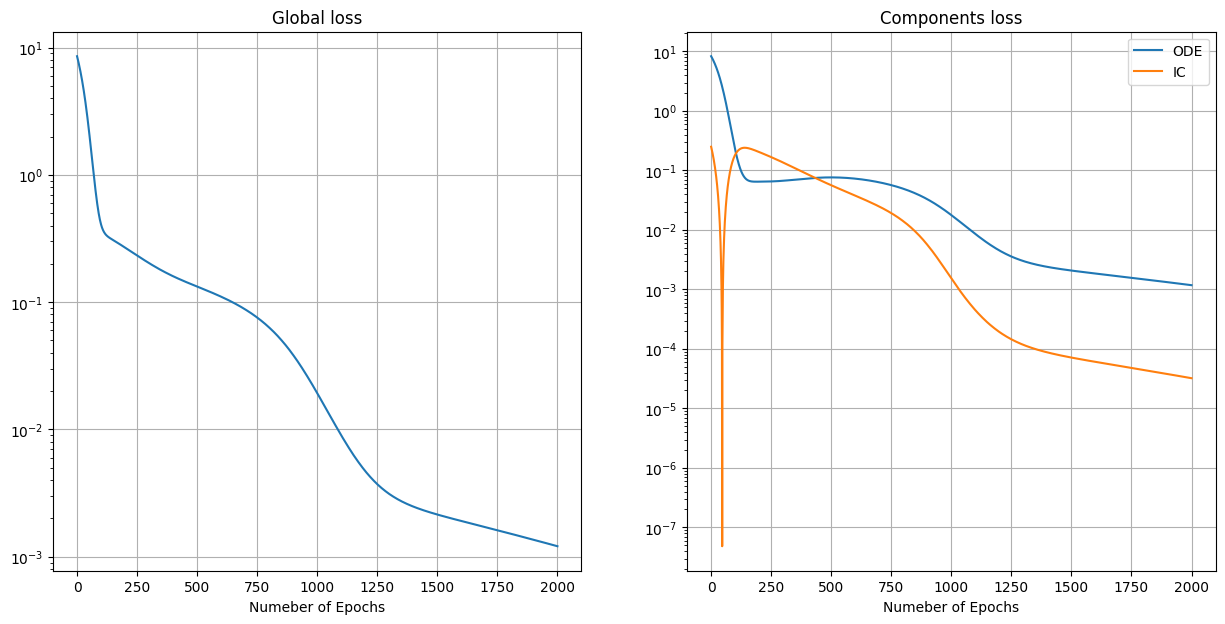

In [9]:
epochs = range(n_epochs+1)
#y_lims = [np.min(loss_values)*0.8,np.max(loss_values)*1.2]

fig, axs = plt.subplots(1,2,figsize = (15,7), num =4)
axs[0].semilogy(epochs,loss_values[:,0])
axs[0].set_xlabel('Numeber of Epochs')
#axs[0].set_ylim(y_lims)
axs[0].grid('on')
axs[0].set_title('Global loss')

axs[1].semilogy(epochs,loss_values[:,1],label = 'ODE')
axs[1].semilogy(epochs,loss_values[:,2],label = 'IC' )
axs[1].set_xlabel('Numeber of Epochs')
#axs[1].set_ylim(y_lims)
axs[1].legend()
axs[1].grid('on')
axs[1].set_title('Components loss')

plt.show()

Compare the exact solution with the PINN prediction and evaluate the point-wise error

In [10]:
t_test = convert(t_test)
y_NN_test = convert(y_NN_test)
t_sort_train = convert(t_sort_train)

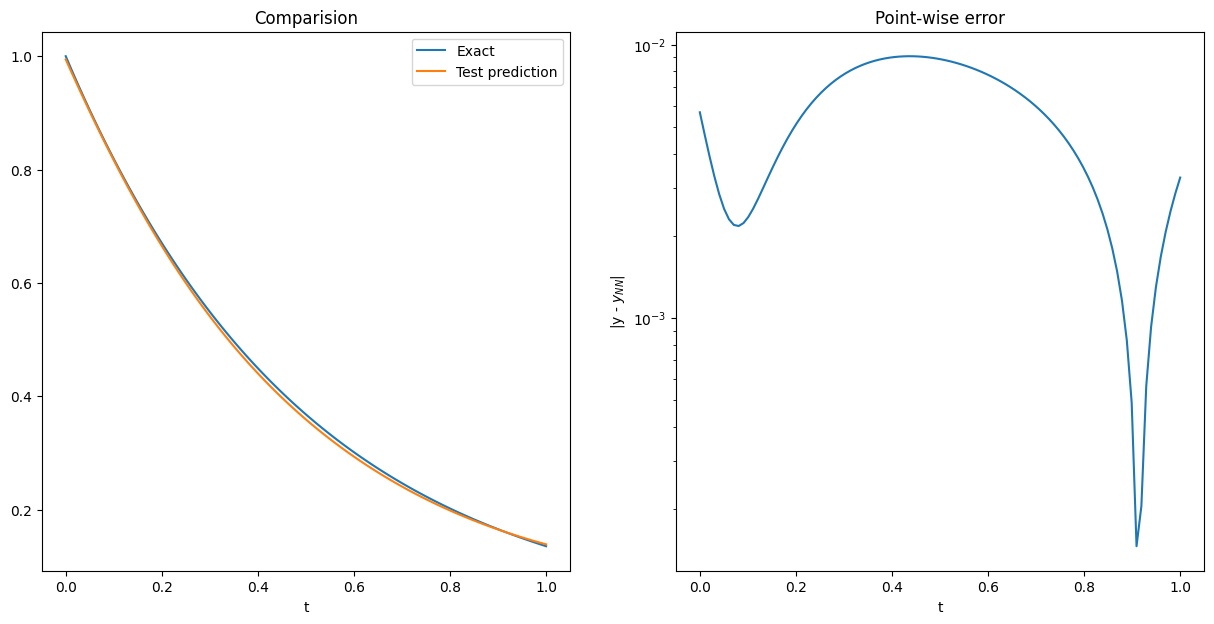

In [11]:
fig, axs = plt.subplots(1,2,figsize = (15,7))
axs[0].plot(t_test,y_exact_test,label = 'Exact')
axs[0].plot(t_test,y_NN_test, label = 'Test prediction')
axs[0].set_xlabel('t')
axs[0].legend()
axs[0].set_title('Comparision')

axs[1].semilogy(t_test,np.abs(y_exact_test-y_NN_test))
axs[1].set_title('Point-wise error')
axs[1].set_xlabel('t')
axs[1].set_ylabel('|y - $y_{NN}$|')
plt.show()

$L^2$ Errors

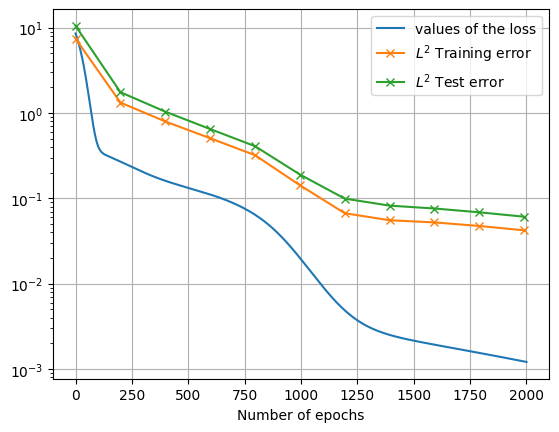

In [12]:

epochs = range(n_epochs+1)
y_lims = [np.min(loss_values)*0.8,np.max(loss_values)*1.2]
plt.figure(4)
plt.semilogy(epochs,loss_values[:,0],label = 'values of the loss')
plt.semilogy(epochs[0:-1:STEP-1],err[:,0],'-x', label = '$L^2$ Training error')
plt.semilogy(epochs[0:-1:STEP-1],err[:,1],'-x', label = '$L^2$ Test error')

plt.xlabel('Number of epochs')
plt.grid('on')
plt.legend()
plt.show()

Animation of the solution and of the point wise error during training

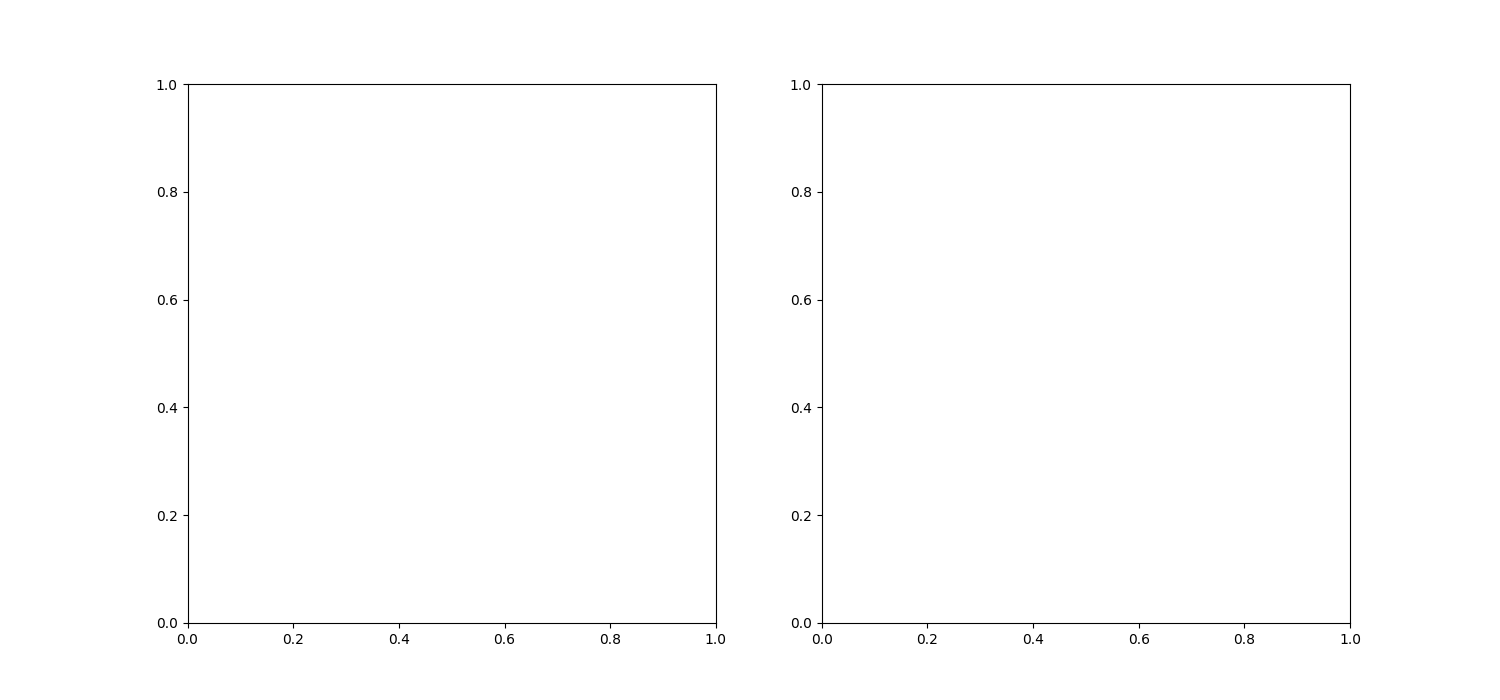

In [13]:
%matplotlib widget
fig, axs = plt.subplots(1,2, figsize = (15,7),num = 3)

def updata_data(frame):
    axs[0].clear()
    axs[0].plot(t_sort_train,y_animate[frame,:],'b--',label = r'$y_{\Theta}$')
    axs[0].plot(t_sort_train,y_exact_train_sort,'r', label = 'Exact')
    axs[0].set_ylim([0,1.1])
    axs[0].set_xlim([0,1])
    axs[0].set_xlabel('t')

    axs[0].grid('on')
    axs[0].legend()

    axs[1].clear()
    axs[1].semilogy(t_sort_train,err_animate[frame,:])
    axs[1].grid('on')
    axs[1].set_ylim([np.min(err_animate)*0.9,np.max(err_animate)*1.1])
    axs[1].set_xlabel('t')
    axs[1].set_title(r'$|y - y_{\Theta}|$')
    plt.suptitle(f'Epoch {frame*STEP} || error {err[frame,0]:.2e}')
    return axs[0]

animation = FuncAnimation(fig,func = updata_data,frames=len(y_animate),interval = 500,)
plt.show()
#for google colab
#from IPython.display import HTML
#video = HTML(anim.to_html5_video())
#display(video)
#plt.close()